In [25]:
import fitsio
import numpy as np
import scipy as sp
from scipy import constants
from astropy.io import ascii,fits

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib._color_data as mcd
import matplotlib.patches as mpatches

In [27]:
# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = [mcd.CSS4_COLORS['lightskyblue'],mcd.CSS4_COLORS['dodgerblue'],mcd.CSS4_COLORS['royalblue'],mcd.CSS4_COLORS['blue']]

In [28]:
def zeropad(input, N=4):
    '''
    Extend the size of an input string of integers to length N
    '''

    #if type(input) == str:
    #    if len(input) > N:
    #        print("Error: len(%s) > %d" % (input, N))
    #    while len(input) < N:
    #        input = '0' + input
    #else:
    #    print("Error: Argument must be a string")
    if type(input) == str:
        if N == 3:
            output = "{:03d}".format(int(input))
        elif N == 4:
            output = "{:04d}".format(int(input))
        elif N == 5:
            output = "{:05d}".format(int(input))
        else:
            print("Error: Only works for N = 3 to 5")
            output = str(input)
    else:
        print("Error: Argument must be a string")
        output = str(input)
    return output
def getspecfromid(plate, mjd, fiberid):
    plate4 = str(plate)
    fiberid4 = str(fiberid)
    mjd = str(mjd)
    plate4 = zeropad(plate4)
    fiberid4 = zeropad(fiberid4)
    #print(array['Z'])
    ebossdir = '/global/projecta/projectdirs/sdss/staging/dr14/eboss/spectro/redux/v5_10_0/spectra/lite/'
    specfits = "spec-%s-%s-%s.fits" % (plate4, mjd, fiberid4)
    ebossfile = ebossdir + plate4 + "/" + specfits
    return(ebossfile)

In [61]:
def getYAxLim(z_rs,loglam,flux):
    '''
    Returns max and min y axis points for plotting, based on max flux in forest range 1000 - 1600 Angstroms
    '''
    #Get the indicies of the loglam that are in plotting range
    xmin_ll = np.log10(1000*(1+z_rs))
    xmax_ll = np.log10(1600*(1+z_rs))
    indicies = np.where((loglam > xmin_ll)&(loglam < xmax_ll))
    
    #select flux values based on that index range
    y_plotted = flux[indicies]
    #get the max and min values
    yAxMin = np.amin(y_plotted)
    yAxMax = np.amax(y_plotted)
    
    #pad 5% for readabliltiy
    yAdjust = abs(yAxMax-yAxMin)*0.05
    yAxMin = yAxMin-yAdjust
    yAxMax = yAxMax+yAdjust

    return yAxMin, yAxMax, yAdjust

def plotFromIndex(indx,maskedHdu):
    '''
    Plots eBoss spectra from BAL catalog
    '''
    z_rs = maskedHdu['Z'][indx]
    mag = maskedHdu['PSFMAG'][indx][1]
    AIval = maskedHdu['AI_CIV'][indx]
    plate = maskedHdu['PLATE'][indx]
    mjd = maskedHdu['MJD'][indx]
    fiberid = maskedHdu['FIBERID'][indx]
    sdss_name = maskedHdu['SDSS_NAME'][indx]
    
    specfile = getspecfromid(plate, mjd, fiberid)
    hdu = fits.open(specfile)
    
    plt.figure(figsize=(10,7))
    fsize = 20
    plt.plot((10**hdu[1].data['loglam'])/(1+z_rs),hdu[1].data['flux'], color='k')

    plt.xlim(1000,1600)
    yAxmin, yAxmax, yAdjust = getYAxLim(z_rs,hdu[1].data['loglam'], hdu[1].data['flux'])
    plt.ylim(yAxmin, yAxmax)
    
    plt.xlabel(r'Rest Frame $\lambda$ (Ang)', fontsize=fsize)
    plt.ylabel(r'Flux', fontsize=fsize)

    plt.text(1260,yAxmax-2*yAdjust, r'SDSS {}'.format(sdss_name), fontsize=fsize)
    plt.text(1260,yAxmax-4*yAdjust,r'Z={}, Mag={:2.2f}'.format(z_rs, mag), fontsize=fsize)
    plt.text(1260,yAxmax-6*yAdjust,r'AI={:3.2f}'.format(AIval), fontsize=fsize)
    
    #shade forest analysis region
    ax=plt.gca()
    #forest = mpatches.Rectangle((1040,yAxmin+1.5*yAdjust),1200-1040,yAxmin+7*yAdjust,color='y', alpha = 0.5)
    #ax.add_patch(forest)
    plt.hlines(yAxmin+7*yAdjust,1040,1200, color =mcd.CSS4_COLORS['darkgoldenrod'])
    plt.text(1060,yAxmin+7.3*yAdjust,r'Ly$\alpha$ forest', fontsize=fsize, color=mcd.CSS4_COLORS['darkgoldenrod'])
    
    
    #shade BAL absorption regions
    masklist,ai = MaskBALs(maskedHdu,indx,'ai')
    for i,line in enumerate(masklist):
        xmin = line[0]
        xmax = line[1]
        xrange = xmax-xmin
        bal_patch = mpatches.Rectangle((xmin,yAxmin+1.5*yAdjust),xrange,yAxmin+7*yAdjust,color=mcd.CSS4_COLORS['orangered'], alpha=0.5)
        ax.add_patch(bal_patch)

    
    #mark CIV, LyA, NV emmssion lines
    
    eline_color = mcd.CSS4_COLORS['blue']
    abline_color = mcd.CSS4_COLORS['dodgerblue']
    ax.axvline(1549,0.1,0.5,color=eline_color) #CIV
    plt.text(1500,yAxmin+10*yAdjust,r'C$_{4}$', fontsize=fsize, color=eline_color)
    ax.axvline(1216.5,0.1,0.9,color=eline_color)#LYA
    plt.text(1170,yAxmin+12*yAdjust,r'Ly$\alpha$', fontsize=fsize, color=eline_color)
    ax.axvline(1240.81,0.1,0.5,color=eline_color)#NV
    plt.text(1244,yAxmin+10*yAdjust,r'N$_{5}$', fontsize=fsize, color=eline_color)
    #mark LyB & Oxygen lines
    ax.axvline(1020,0.1,0.9,color=eline_color) #LYB
    plt.text(1024,yAxmin+12*yAdjust,r'Ly$\beta$', fontsize=fsize, color=eline_color)
    ax.axvline(1031,0.1,0.5,color=abline_color) #OVI
    ax.axvline(1037,0.1,0.5,color=abline_color) #OVI
    plt.text(1042,yAxmin+9*yAdjust,r'O$_{4}$ lines', fontsize=fsize, color=abline_color)
    
    return(plt)

In [60]:
def MaskBALs(bcat,indx,BALi='AI'):
    ls = sp.constants.c*10**-3

    if BALi == 'BI':
        lst = ['VMIN_CIV_2000','VMAX_CIV_2000']
    elif BALi == 'BOTH':
        lst = ['VMIN_CIV_450','VMAX_CIV_450','VMIN_CIV_2000','VMAX_CIV_2000']
    else: ##Leaving AI as default
        lst = ['VMIN_CIV_450','VMAX_CIV_450']

    lines = {
        "lCIV" : 1549, #Used for testing
        "lNV" : 1240.81,
        "lLya" : 1216.1,
        "lLyb" : 1020,
        "lOVI" : 1037,
        "lOI" : 1039
        #"lPV1" : 1117,
        #"lPV2" : 1128,
        #"lSIV1" : 1062,
        #"lSIV2" : 1074,
        #"lC3"   : 1175
    }
        
    bal_mask_rf = []

    vMin = []
    vMax = []
    
    for i in lst:
        if i.find('VMIN') == 0:
            velArr = bcat[i]
            for j in velArr[indx]:
                if j > 0:
                    vMin.append(j)
        else:
            velArr = bcat[i]
            for j in velArr[indx]:
                if j > 0:
                    vMax.append(j)
                    
    for i in range(len(vMin)):
        for lin in lines.values():
            lMin = lin*(1-vMin[i]/ls)
            lMax = lin*(1-vMax[i]/ls)
            bal_mask_rf += [[lMin, lMax]]

    return bal_mask_rf,bcat['AI_CIV'][indx]

In [31]:
def CombineMasks(bal_mask):
    bal_mask = np.sort(bal_mask,axis=0)
    combo_mask = []
        
    lowest = bal_mask[0][0]
    highest = bal_mask[0][1]
    for i in range(len(bal_mask)-1):
    
        #overlap case. First check if overlap with next iteration:
        if ((bal_mask[i+1][0]<bal_mask[i][1]) | (bal_mask[i][0]<bal_mask[i-1][1])):
        #Assign [i+1][1] to be temporary highest value
            high = bal_mask[i][1]
            #Assign i be temporary lowest value
            low = bal_mask[i][0]
        
            #redefine lowest once
            if low > highest:
                lowest = low
            
            #re-define highest no overlap with next
            if high > highest:
                highest = high

            #Only return if lowest value changes
            if bal_mask[i+1][0]>highest:
                #print(str(lowest) + ' ' + str(highest))
                combo_mask += [[lowest,highest]]
                
        #basic, single mask case:
        elif (bal_mask[i+1][0]>bal_mask[i][1]):
            lowest = bal_mask[i][0]
            highest = bal_mask[i][1]

            #print(str(lowest) + ' ' + str(highest))
            combo_mask += [[lowest,highest]]
        

    return combo_mask

In [56]:
def GetPLRange(data,indx,LYAF_Lam=[1040,1200]):

    bal_mask,ai_val = MaskBALs(data,indx)
    #print(len(bal_mask))
    if len(bal_mask) == 0: 
        combo_mask = bal_mask
    else:
        combo_mask = CombineMasks(bal_mask)
    #print(combo_mask)

    LyaTot = LYAF_Lam[1]-LYAF_Lam[0]
    LyaTot_start = LyaTot
    for i,wl in enumerate(combo_mask):
        #print(wl)
        #skip lines that are outside the forest region
        if wl[0] > LYAF_Lam[1]:
            continue
        if wl[1] < LYAF_Lam[0]:
            continue

        below=0
        above=0
        allelse=0
        #edge cases
        if ((wl[0] < LYAF_Lam[0]) & (wl[1] > LYAF_Lam[0])):
            LyaTot = LyaTot - (wl[1]-LYAF_Lam[0])
        if ((wl[1] > LYAF_Lam[1]) & (wl[0] < LYAF_Lam[1])):
            LyaTot = LyaTot - (LYAF_Lam[1]-wl[0])
        
        #everything else
        if (wl[0] > LYAF_Lam[0]) & (wl[1] < LYAF_Lam[1]):
            LyaTot = LyaTot - (wl[1]-wl[0])
        
    lya_ratio = (LyaTot/LyaTot_start-1)*100
    if (lya_ratio < -50) & (lya_ratio > -75):
        #print(lya_ratio)
        lya_ratio = -100
        balplt = plotFromIndex(indx,data)
        balplt.savefig('PaperPlots/MaskedPL_50-75_' + str(indx) + '.png')
        #balplt.show()
        
    return [lya_ratio, ai_val]

In [33]:
bal_catalog = '/global/homes/l/lennesse/Catalogs/DR14Q_BAL_v_2_0.fits'

In [34]:
#Redshift cut
h = fits.open(bal_catalog)
zmask = h[1].data['Z'] > 2.53
print(len(zmask))
lyaBALdata = h[1].data[zmask]
print(len(lyaBALdata))

53760
16263


In [35]:
aiCuts = [249.81,839.0,2221.6,10000]
aiCutsMin = [0,249.81,839.0,2221.6]

0.0
-2.3718764666003977
-5.35537958440081
-15.954082632575105


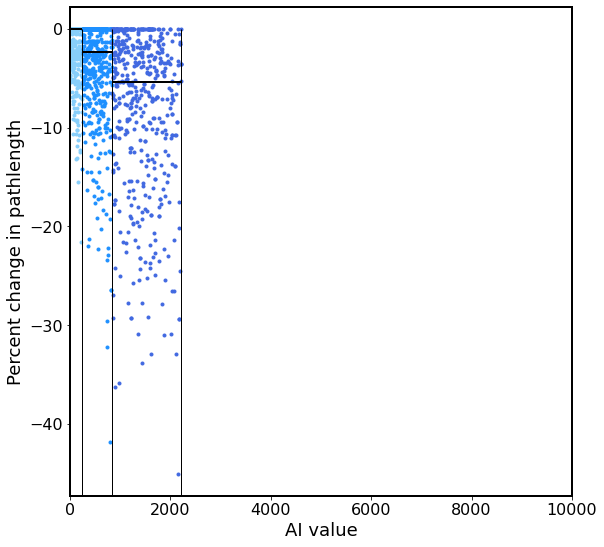

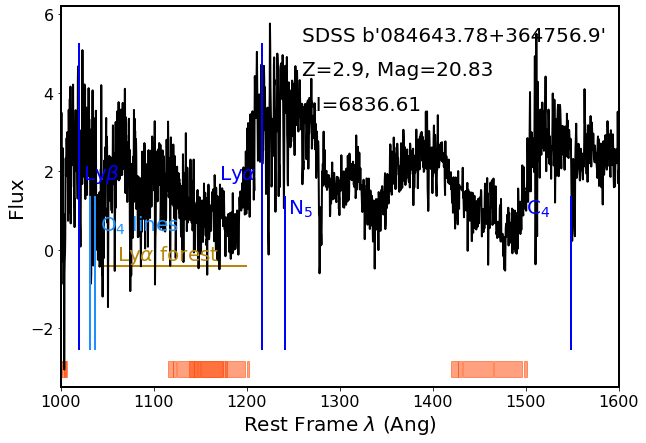

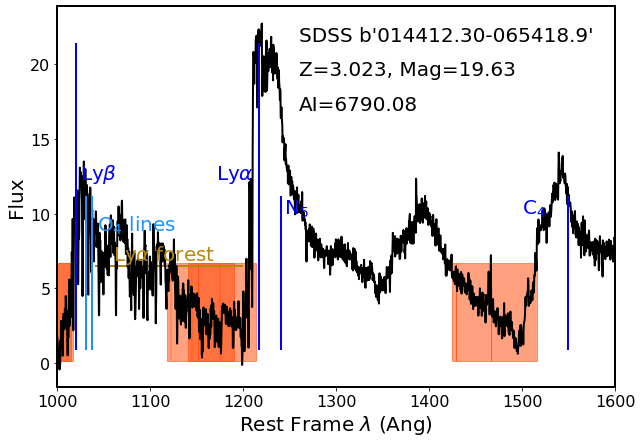

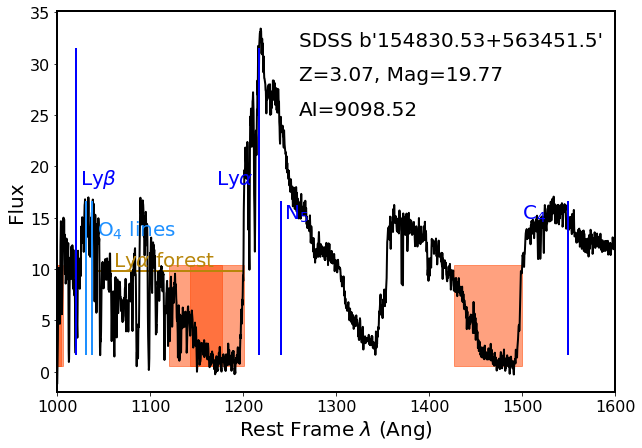

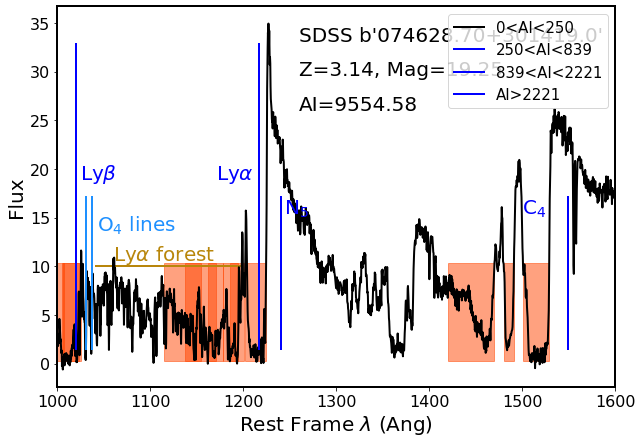

In [71]:
plt.figure(figsize=(9,9))
#plt.xlim(0,aiCuts[2])
plt.xlim(0,10000)
plt.xlabel(r'AI value')
plt.ylabel(r'Percent change in pathlength')

for i,val in enumerate(aiCuts):
#    print(val)
    yax = []
    xax = []
    aiMask = (lyaBALdata['AI_CIV'] < val) & (lyaBALdata['AI_CIV']>=aiCutsMin[i])
    maskedData = lyaBALdata[aiMask]
    
    randoData = np.random.choice(maskedData,500)
    for j,k in enumerate(randoData):
        y,x = GetPLRange(randoData,j)
        yax = np.append(yax,y)
        xax = np.append(xax,x)
        
    plt.plot(xax,yax,color=colors[i],marker='.',linewidth=0,zorder=1)
    
    plt.hlines(np.median(yax),aiCutsMin[i],val,color='k',zorder=2)
    plt.arrow(val, 0.0, 0, -90, color='k',zorder=3)
    print(np.median(yax))
    
plt.legend(fontsize=15,loc="upper right",labels=['0<AI<250','250<AI<839','839<AI<2221','AI>2221'])
#plt.savefig('PaperPlots/AIvsPLChange_SomeMasking.png')
#plt.plot(xax,yax,color='blue',marker='.',linewidth=0)
    

In [61]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>